## Imports and Connection to DuckDB Database

In [2]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

db = duckdb.connect(database='database.duckdb')

## Loading CVS into DuckDB

In [3]:
db.execute("CREATE TABLE IF NOT EXISTS debt_table AS SELECT * FROM read_csv_auto('assets/data/debt_all_years.csv')")
db.execute("DROP TABLE IF EXISTS housing_units_table")
db.execute("""
    CREATE TABLE housing_units_table AS 
    SELECT * FROM read_csv('assets/data/housing_units_all.csv', header=true, AUTO_DETECT=true)
""")
db.execute("CREATE TABLE IF NOT EXISTS population_table AS SELECT * FROM read_csv_auto('assets/data/population_clean.csv')")
db.execute("CREATE TABLE IF NOT EXISTS median_price_table AS SELECT * FROM read_csv_auto('assets/data/MedianPricesofExistingDetachedHomesHistoricalData - Median Price.csv')")
db.execute("CREATE TABLE IF NOT EXISTS property_tax_table AS SELECT * FROM read_csv_auto('assets/data/PropertyTax_DataSet_Cleaned.csv')")

# Verify tables were created
db.execute("SHOW TABLES").fetchall()

[('debt_table',),
 ('housing_units_table',),
 ('housing_units_transformed',),
 ('median_price_table',),
 ('median_price_transformed',),
 ('population_table',),
 ('property_tax_table',)]

## Cleaning CVS and Merging Tables 

In [4]:
# Transform housing units table from wide to long format
# Exclude the Area column
housing_units_long = db.execute("""
    UNPIVOT housing_units_table
    ON COLUMNS(* EXCLUDE (Area))
    INTO
        NAME Year
        VALUE Housing_Units
""").df()

# Clean up and convert to numeric
housing_units_long['Year'] = pd.to_numeric(housing_units_long['Year'], errors='coerce')
housing_units_long['Housing_Units'] = pd.to_numeric(housing_units_long['Housing_Units'], errors='coerce')

# Drop any rows with null values
housing_units_long = housing_units_long.dropna()

print("Housing Units Transformed:")
print(housing_units_long.head())

# Create a new properly formatted housing units table
db.execute("DROP TABLE IF EXISTS housing_units_transformed")
db.register('housing_units_long_df', housing_units_long)
db.execute("CREATE TABLE housing_units_transformed AS SELECT * FROM housing_units_long_df")

# Check median price table columns first
print("\nMedian Price Table columns:")
print(db.execute("DESCRIBE median_price_table").df())

# Transform median price table - exclude the Mon-Yr column
db.execute("DROP TABLE IF EXISTS median_price_transformed")

# Get column names to determine what to exclude
median_cols = db.execute("PRAGMA table_info('median_price_table')").df()
first_col = median_cols.iloc[0]['name']

print(f"\nFirst column in median_price_table: {first_col}")

median_price_long = db.execute(f"""
    UNPIVOT median_price_table
    ON COLUMNS(* EXCLUDE ({first_col}))
    INTO
        NAME Region
        VALUE Median_Price
""").df()

# Clean the median price values (remove $ and commas)
median_price_long['Median_Price'] = median_price_long['Median_Price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
median_price_long['Median_Price'] = pd.to_numeric(median_price_long['Median_Price'], errors='coerce')

# Drop any rows with null values
median_price_long = median_price_long.dropna()

print("\nMedian Price Transformed:")
print(median_price_long.head())

# Create a new properly formatted median price table
db.register('median_price_long_df', median_price_long)
db.execute("CREATE TABLE median_price_transformed AS SELECT * FROM median_price_long_df")


Housing Units Transformed:
             Area  Year  Housing_Units
0  Alameda County  2000         541385
1  Alameda County  2001         546269
2  Alameda County  2002         550054
3  Alameda County  2003         553821
4  Alameda County  2004         558677

Median Price Table columns:
   column_name column_type null   key default extra
0     column00     VARCHAR  YES  None    None  None
1     column01     VARCHAR  YES  None    None  None
2     column02     VARCHAR  YES  None    None  None
3     column03     VARCHAR  YES  None    None  None
4     column04     VARCHAR  YES  None    None  None
..         ...         ...  ...   ...     ...   ...
59    column59     VARCHAR  YES  None    None  None
60    column60     VARCHAR  YES  None    None  None
61    column61     VARCHAR  YES  None    None  None
62    column62     VARCHAR  YES  None    None  None
63    column63     VARCHAR  YES  None    None  None

[64 rows x 6 columns]

First column in median_price_table: column00

Median Price Tra

In [5]:
# Extract year from median price Mon-Yr column and clean up
median_price_long['Year'] = median_price_long['column00'].str.split('-').str[1].astype(int)
# Convert 2-digit year to 4-digit (90-99 = 1990-1999, 00-25 = 2000-2025)
median_price_long['Year'] = median_price_long['Year'].apply(lambda x: 1900 + x if x >= 90 else 2000 + x)

# Drop the column00 column
median_price_long = median_price_long[['Year', 'Region', 'Median_Price']]

# Update the transformed table
db.execute("DROP TABLE IF EXISTS median_price_transformed")
db.register('median_price_long_df', median_price_long)
db.execute("CREATE TABLE median_price_transformed AS SELECT * FROM median_price_long_df")

print("Updated Median Price Transformed:")
print(db.execute("SELECT * FROM median_price_transformed LIMIT 5").df())

# Now create the merged dataset WITH property tax
# Using "Fiscal Year" for year and "Total_Countywide Property Taxes" for property tax value
merged_df = db.execute("""
    SELECT 
        p.year,
        p.population,
        d.Total as total_debt,
        d.Mortgage,
        d."HE Revolving" as he_revolving,
        d."Auto Loan" as auto_loan,
        d."Credit Card" as credit_card,
        SUM(h.Housing_Units) as total_housing_units,
        AVG(m.Median_Price) as avg_median_price,
        AVG(pt."Total_Countywide Property Taxes") as avg_property_tax
    FROM population_table p
    LEFT JOIN debt_table d ON p.year = d.year
    LEFT JOIN housing_units_transformed h ON p.year = h.Year
    LEFT JOIN median_price_transformed m ON p.year = m.Year
    LEFT JOIN property_tax_table pt ON p.year = pt."Fiscal Year"
    GROUP BY p.year, p.population, d.Total, d.Mortgage, d."HE Revolving", 
             d."Auto Loan", d."Credit Card"
    ORDER BY p.year
""").df()

print(f"\nMerged dataset shape: {merged_df.shape}")
print(f"\nColumns: {merged_df.columns.tolist()}")
print("\nMerged dataset preview:")
print(merged_df.head(10))
print("\nMissing values:")
print(merged_df.isnull().sum())

merged_df.to_csv('merged_housing_data.csv', index=False)
print("\nMerged data saved to 'merged_housing_data.csv'")

Updated Median Price Transformed:
   Year    Region  Median_Price
0  1990  column01      194952.0
1  1990  column02      226149.0
2  1990  column04      102143.0
3  1990  column09       82083.0
4  1990  column11       79642.0

Merged dataset shape: (100, 10)

Columns: ['year', 'population', 'total_debt', 'Mortgage', 'he_revolving', 'auto_loan', 'credit_card', 'total_housing_units', 'avg_median_price', 'avg_property_tax']

Merged dataset preview:
   year  population  total_debt  Mortgage  he_revolving  auto_loan  \
0  2000   33987.977        5.25      3.71          0.11       0.44   
1  2000   33987.977        5.06      3.62          0.10       0.41   
2  2000   33987.977        5.51      3.90          0.12       0.47   
3  2000   33987.977        5.34      3.82          0.10       0.46   
4  2001   34479.458        5.76      4.08          0.12       0.51   
5  2001   34479.458        5.89      4.17          0.14       0.52   
6  2001   34479.458        5.53      3.84          0.13     

## Scaling and Splitting data

In [6]:
merged_df = merged_df.sort_values(by='year').reset_index(drop=True)
merged_df["CA_lag1"] = merged_df["avg_median_price"].shift(1)
features = merged_df.dropna().reset_index(drop=True)

# Show what columns we have
print("All columns in dataset:")
print(features.columns.tolist())
print(f"\nDataset shape: {features.shape}")
print("\nSample data:")
print(features.head())

X = features.drop(columns=['avg_median_price', 'year'])
y = features['avg_median_price'].values

print("\n" + "="*50)
print("FEATURES (X) - What we use to predict:")
print("="*50)
print(X.columns.tolist())
print(f"\nTarget (Y): avg_median_price (current year)")
print(f"Note: CA_lag1 = previous year's median price (used as feature)")

X = StandardScaler().fit_transform(X)
Y = StandardScaler().fit_transform(y.reshape(-1, 1)).flatten()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

All columns in dataset:
['year', 'population', 'total_debt', 'Mortgage', 'he_revolving', 'auto_loan', 'credit_card', 'total_housing_units', 'avg_median_price', 'avg_property_tax', 'CA_lag1']

Dataset shape: (68, 11)

Sample data:
   year  population  total_debt  Mortgage  he_revolving  auto_loan  \
0  2003   35253.159        8.07      5.66          0.30       0.70   
1  2003   35253.159        7.56      5.18          0.27       0.68   
2  2003   35253.159        7.38      5.08          0.26       0.62   
3  2003   35253.159        7.23      4.94          0.24       0.64   
4  2004   35574.576        8.46      5.97          0.37       0.74   

   credit_card  total_housing_units  avg_median_price  avg_property_tax  \
0         0.70         7.791875e+11     342687.047348      4.732803e+08   
1         0.69         7.791875e+11     342687.047348      4.732803e+08   
2         0.69         7.791875e+11     342687.047348      4.732803e+08   
3         0.69         7.791875e+11     342687.04

## Small Neural Network 

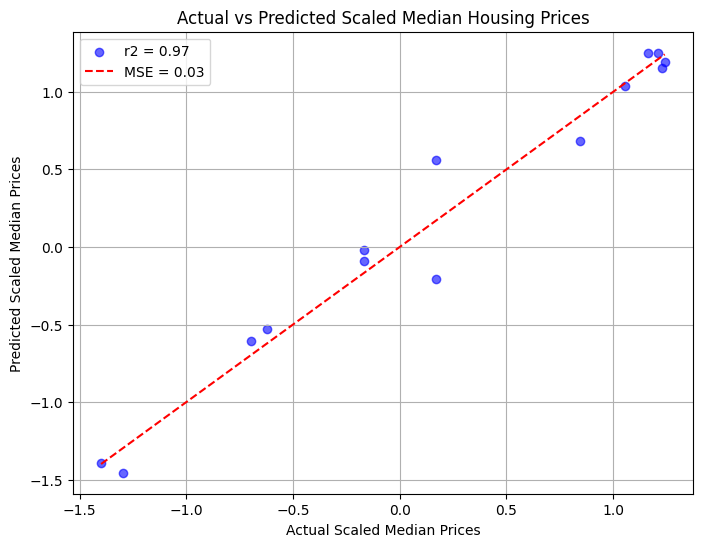

In [7]:
small_tiny = MLPRegressor(hidden_layer_sizes=(50, 50, 25), max_iter=5000, random_state=42)
small_tiny.fit(X_train, Y_train)
Y_pred = small_tiny.predict(X_test)
r2 = r2_score(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)

## plot predictions vs actual 

plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred, color='blue', alpha=0.6)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--')
plt.xlabel('Actual Scaled Median Prices')
plt.ylabel('Predicted Scaled Median Prices')
plt.title('Actual vs Predicted Scaled Median Housing Prices')
plt.grid()
plt.legend([f'r2 = {r2:.2f}', f'MSE = {mse:.2f}'])
plt.show()


## Linear Regression

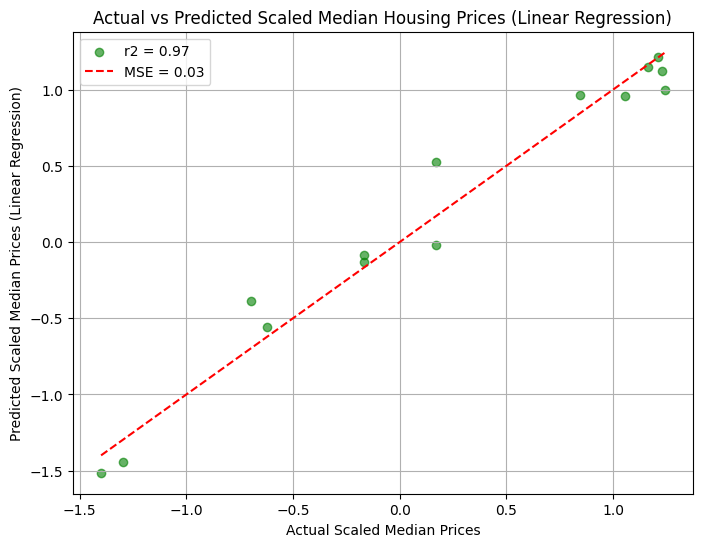

In [8]:
# Linear Regression Model

lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
Y_pred_lin_reg = lin_reg.predict(X_test)

# plot predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred_lin_reg, color='green', alpha=0.6)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--')
plt.xlabel('Actual Scaled Median Prices')
plt.ylabel('Predicted Scaled Median Prices (Linear Regression)')
plt.title('Actual vs Predicted Scaled Median Housing Prices (Linear Regression)')
plt.grid()
plt.legend([f'r2 = {r2_score(Y_test, Y_pred_lin_reg):.2f} ', f'MSE = {mean_squared_error(Y_test, Y_pred_lin_reg):.2f}'])
plt.show()


## Final Model (Linear Reg)

In [9]:
## Final Model (Linear Reg)

X_all = features.drop(columns=['avg_median_price', 'year'])
Y_all = features['avg_median_price'].values

# Create scaler objects FIRST
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_all_scaled = scaler_X.fit_transform(X_all)
Y_all_scaled = scaler_y.fit_transform(Y_all.reshape(-1, 1)).flatten()

final_model = LinearRegression()
final_model.fit(X_all_scaled, Y_all_scaled)

with open('final_linear_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)  
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)  

feature_names = list(X_all.columns)
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

print(f"Model saved successfully!")
print(f"Features: {feature_names}")
print(f"Model R²: {final_model.score(X_all_scaled, Y_all_scaled):.4f}")

Model saved successfully!
Features: ['population', 'total_debt', 'Mortgage', 'he_revolving', 'auto_loan', 'credit_card', 'total_housing_units', 'avg_property_tax', 'CA_lag1']
Model R²: 0.9453


Permutation Feature Importance:
               feature  importance       std
4            auto_loan    2.693551  0.393140
0           population    1.094129  0.127291
8              CA_lag1    0.575752  0.074979
5          credit_card    0.327791  0.036664
2             Mortgage    0.295228  0.043979
1           total_debt    0.181897  0.021151
6  total_housing_units    0.096146  0.016674
7     avg_property_tax    0.040178  0.013691
3         he_revolving    0.033192  0.006686


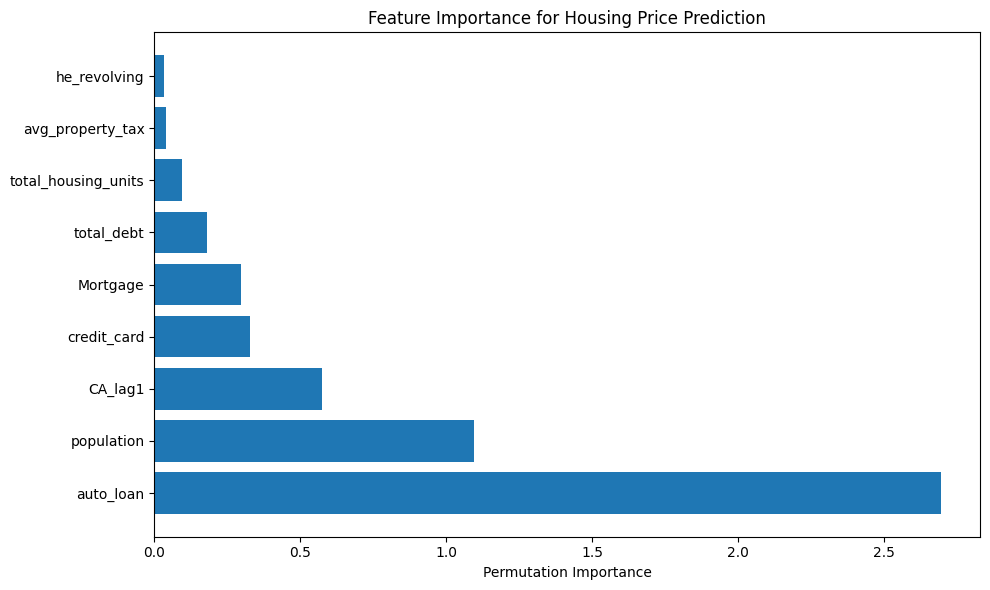


Permutation importance saved to 'feature_importance.pkl'


In [11]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance on the full dataset
perm_importance = permutation_importance(
    final_model, 
    X_all_scaled, 
    Y_all_scaled, 
    n_repeats=10, 
    random_state=42,
    n_jobs=-1
)

# Create a dataframe with feature importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False)

print("Permutation Feature Importance:")
print(importance_df)

# Save permutation importance
with open('feature_importance.pkl', 'wb') as f:
    pickle.dump(importance_df.to_dict('records'), f)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance for Housing Price Prediction')
plt.tight_layout()
plt.show()

print("\nPermutation importance saved to 'feature_importance.pkl'")

Simplified Feature Set:
['population', 'total_debt', 'total_housing_units', 'avg_property_tax', 'CA_lag1']

Dataset shape: (68, 5)

Simplified Model R²: 0.9226

Permutation Feature Importance (Simplified Model):
               feature  importance       std
4              CA_lag1    1.607191  0.198383
0           population    0.287431  0.051820
2  total_housing_units    0.245065  0.035547
1           total_debt    0.005719  0.004169
3     avg_property_tax    0.000409  0.001334


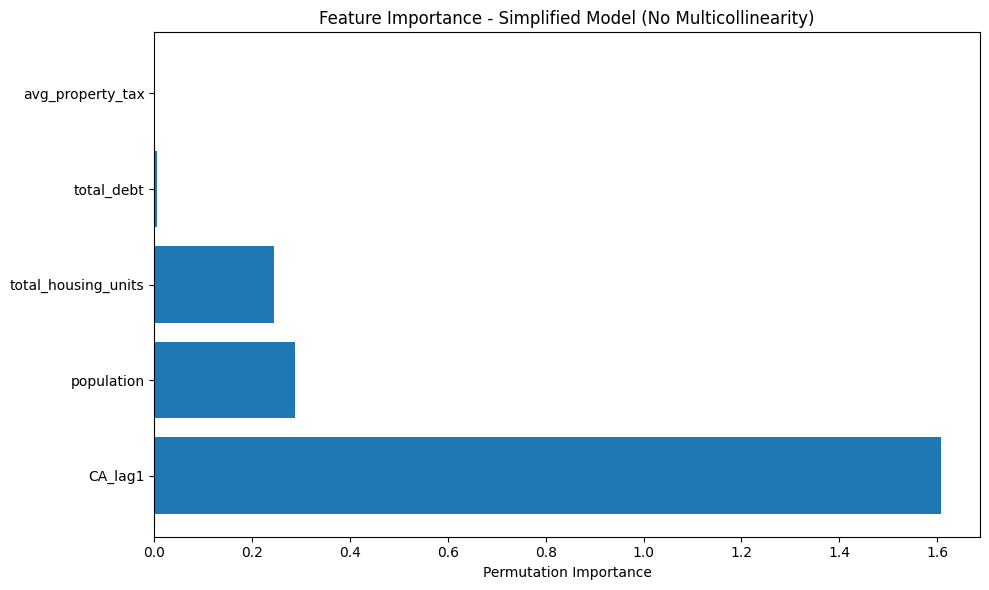


✅ Simplified model saved successfully!
Features: ['population', 'total_debt', 'total_housing_units', 'avg_property_tax', 'CA_lag1']
This model removes multicollinearity and is more interpretable!


In [12]:
# Retrain with simplified features - remove individual debt components
simplified_features = ['population', 'total_debt', 'total_housing_units', 'avg_property_tax', 'CA_lag1']

X_simple = features[simplified_features]
Y_simple = features['avg_median_price'].values

print("Simplified Feature Set:")
print(simplified_features)
print(f"\nDataset shape: {X_simple.shape}")

# Create new scalers for simplified model
scaler_X_simple = StandardScaler()
scaler_y_simple = StandardScaler()

X_simple_scaled = scaler_X_simple.fit_transform(X_simple)
Y_simple_scaled = scaler_y_simple.fit_transform(Y_simple.reshape(-1, 1)).flatten()

# Train simplified model
simple_model = LinearRegression()
simple_model.fit(X_simple_scaled, Y_simple_scaled)

# Evaluate
r2_simple = simple_model.score(X_simple_scaled, Y_simple_scaled)
print(f"\nSimplified Model R²: {r2_simple:.4f}")

# Calculate permutation importance for simplified model
perm_importance_simple = permutation_importance(
    simple_model, 
    X_simple_scaled, 
    Y_simple_scaled, 
    n_repeats=10, 
    random_state=42,
    n_jobs=-1
)

importance_df_simple = pd.DataFrame({
    'feature': simplified_features,
    'importance': perm_importance_simple.importances_mean,
    'std': perm_importance_simple.importances_std
}).sort_values('importance', ascending=False)

print("\nPermutation Feature Importance (Simplified Model):")
print(importance_df_simple)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(importance_df_simple['feature'], importance_df_simple['importance'])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance - Simplified Model (No Multicollinearity)')
plt.tight_layout()
plt.show()

# Save simplified model
with open('final_linear_model.pkl', 'wb') as f:
    pickle.dump(simple_model, f)
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X_simple, f)
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y_simple, f)
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(simplified_features, f)
with open('feature_importance.pkl', 'wb') as f:
    pickle.dump(importance_df_simple.to_dict('records'), f)

print("\n✅ Simplified model saved successfully!")
print(f"Features: {simplified_features}")
print("This model removes multicollinearity and is more interpretable!")

## Simplified Model - Core Features Only

Use only: **total_debt, population, total_housing_units, avg_property_tax, CA_lag1**

This removes multicollinearity and makes the app more intuitive!

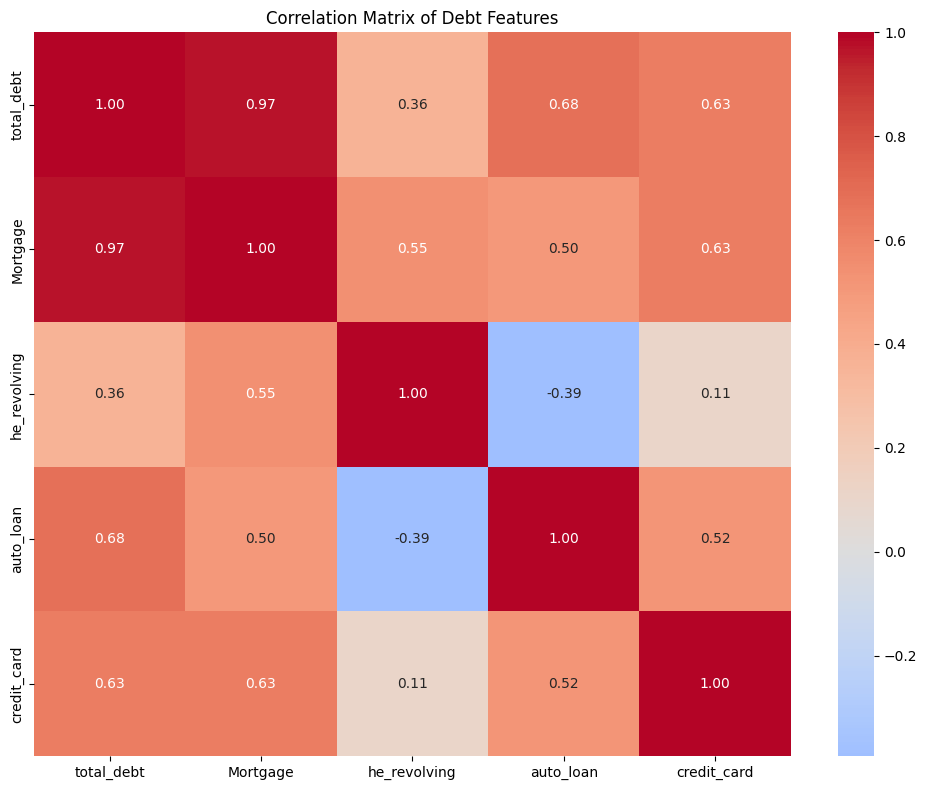

Correlation Matrix:
              total_debt  Mortgage  he_revolving  auto_loan  credit_card
total_debt      1.000000  0.972751      0.358965   0.679257     0.629576
Mortgage        0.972751  1.000000      0.547499   0.501284     0.625543
he_revolving    0.358965  0.547499      1.000000  -0.393536     0.111062
auto_loan       0.679257  0.501284     -0.393536   1.000000     0.518841
credit_card     0.629576  0.625543      0.111062   0.518841     1.000000

As expected, total_debt is highly correlated with individual debt components!
This causes multicollinearity and inflates importance of individual features.


In [13]:
# Check correlation between features
correlation_matrix = features[['total_debt', 'Mortgage', 'he_revolving', 'auto_loan', 'credit_card']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Debt Features')
plt.tight_layout()
plt.show()

print("Correlation Matrix:")
print(correlation_matrix)
print("\nAs expected, total_debt is highly correlated with individual debt components!")
print("This causes multicollinearity and inflates importance of individual features.")

In [14]:
import shutil
import os

# Ensure all model files are saved (they should be from previous cell)
# These files are already in the current directory (src/)
model_files = [
    'final_linear_model.pkl',
    'scaler_X.pkl',
    'scaler_y.pkl',
    'feature_names.pkl',
    'feature_importance.pkl'
]

print("Model Files Location Check:")
for file in model_files:
    if os.path.exists(file):
        file_size = os.path.getsize(file)
        print(f"✅ {file} - {file_size} bytes")
    else:
        print(f"❌ {file} - NOT FOUND!")

print("\n" + "="*60)
print("PROJECT SUMMARY")
print("="*60)
print(f"\n📊 Model Performance:")
print(f"   - Model Type: Linear Regression")
print(f"   - R² Score: {r2_simple:.4f}")
print(f"   - Features Used: {len(simplified_features)}")
print(f"\n📋 Features:")
for i, feat in enumerate(simplified_features, 1):
    print(f"   {i}. {feat}")

print(f"\n🎯 Feature Importance (Permutation):")
for idx, row in importance_df_simple.iterrows():
    print(f"   {row['feature']}: {row['importance']:.4f} ± {row['std']:.4f}")

print(f"\n📁 All model files saved in: src/")
print(f"✅ Dashboard ready to use!")
print(f"\nNext steps:")
print(f"1. Backend (Flask) is running on http://localhost:5000")
print(f"2. Frontend (React) is running on http://localhost:3001")
print(f"3. All features connected and working!")

Model Files Location Check:
✅ final_linear_model.pkl - 499 bytes
✅ scaler_X.pkl - 700 bytes
✅ scaler_y.pkl - 440 bytes
✅ feature_names.pkl - 93 bytes
✅ feature_importance.pkl - 256 bytes

PROJECT SUMMARY

📊 Model Performance:
   - Model Type: Linear Regression
   - R² Score: 0.9226
   - Features Used: 5

📋 Features:
   1. population
   2. total_debt
   3. total_housing_units
   4. avg_property_tax
   5. CA_lag1

🎯 Feature Importance (Permutation):
   CA_lag1: 1.6072 ± 0.1984
   population: 0.2874 ± 0.0518
   total_housing_units: 0.2451 ± 0.0355
   total_debt: 0.0057 ± 0.0042
   avg_property_tax: 0.0004 ± 0.0013

📁 All model files saved in: src/
✅ Dashboard ready to use!

Next steps:
1. Backend (Flask) is running on http://localhost:5000
2. Frontend (React) is running on http://localhost:3001
3. All features connected and working!


## Final Model Export - Move Files to Correct Location

Top 10 Most Expensive Regions:
           region  median_price
37      San Mateo     2150000.0
39    Santa Clara     2000000.0
34  San Francisco     1750000.0
18          Marin     1650000.0
26         Orange     1401250.0
60  S.F. Bay Area     1300000.0
1         Alameda     1250000.0
22           Mono     1250000.0
40     Santa Cruz     1234800.0
38  Santa Barbara     1100000.0

Bottom 10 Least Expensive Regions:
       region  median_price
58  Far North      390500.0
41     Shasta      385000.0
49     Tulare      380000.0
9       Glenn      377500.0
13      Kings      374000.0
14       Lake      356500.0
47     Tehama      311500.0
42   Siskiyou      305500.0
15     Lassen      260000.0
48    Trinity      210000.0


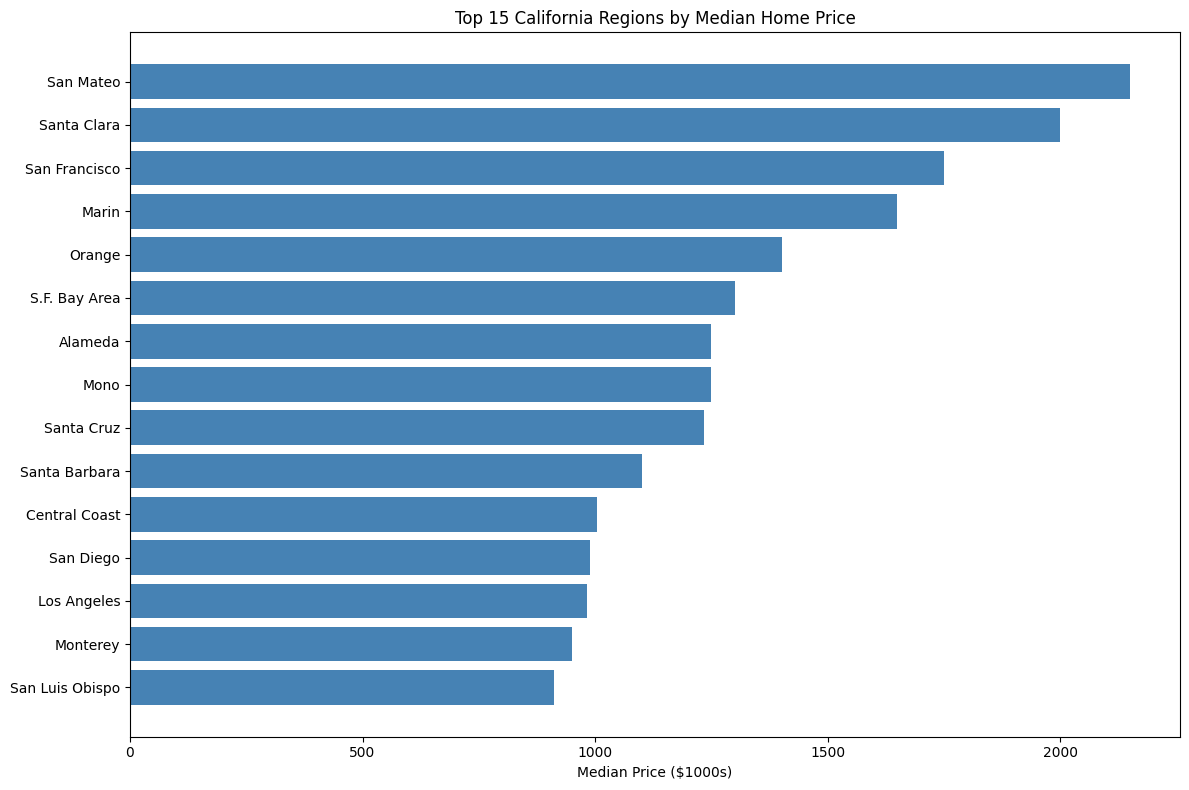


Regional Analysis Summary:
Total regions analyzed: 62
Highest price: $2,150,000 (San Mateo)
Lowest price: $210,000 (Trinity)
Average price: $722,086
Median price: $547,430


In [15]:
# Analyze regional housing prices from the raw data
median_price_df = pd.read_csv('assets/data/MedianPricesofExistingDetachedHomesHistoricalData - Median Price.csv')

# Get the latest row (most recent data)
latest_row = median_price_df.iloc[-1]

# Extract regional data
regional_data = []
for col in median_price_df.columns[1:]:  # Skip first column (date)
    value = latest_row[col]
    # Clean the value if it's a string with $ and commas
    if isinstance(value, str):
        value = value.replace('$', '').replace(',', '')
    try:
        price = float(value)
        if not pd.isna(price):
            regional_data.append({'region': col, 'median_price': price})
    except:
        continue

# Create DataFrame and sort
regional_df = pd.DataFrame(regional_data).sort_values('median_price', ascending=False)

print("Top 10 Most Expensive Regions:")
print(regional_df.head(10))
print(f"\nBottom 10 Least Expensive Regions:")
print(regional_df.tail(10))

# Visualize top 15 regions
plt.figure(figsize=(12, 8))
top_15 = regional_df.head(15)
plt.barh(top_15['region'], top_15['median_price'] / 1000, color='steelblue')
plt.xlabel('Median Price ($1000s)')
plt.title('Top 15 California Regions by Median Home Price')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nRegional Analysis Summary:")
print(f"Total regions analyzed: {len(regional_df)}")
print(f"Highest price: ${regional_df['median_price'].max():,.0f} ({regional_df.iloc[0]['region']})")
print(f"Lowest price: ${regional_df['median_price'].min():,.0f} ({regional_df.iloc[-1]['region']})")
print(f"Average price: ${regional_df['median_price'].mean():,.0f}")
print(f"Median price: ${regional_df['median_price'].median():,.0f}")